### Notebook for web scraping from google images using Selenium

In [15]:
import hashlib
from PIL import Image
import io, os
import requests
import time
from selenium import webdriver
from matplotlib import image
import matplotlib.pyplot as plt
from os import listdir
import numpy as np
import pandas as pd

In [13]:
DRIVER_PATH = "/Applications/chromedriver/chromedriver"
wd = webdriver.Chrome(executable_path= DRIVER_PATH)

In [73]:
def fetch_image_urls(query:str, max_links_to_fetch:int, wd:webdriver, sleep_between_interactions:int=1):
    def scroll_to_end(wd):
        wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(sleep_between_interactions)    
    
    # build the google query
    search_url = "https://www.google.com/search?safe=off&site=&tbm=isch&source=hp&q={q}&oq={q}&gs_l=img"

    # load the page
    wd.get(search_url.format(q=query))

    image_urls = set()
    image_count = 0
    results_start = 0
    while image_count < max_links_to_fetch:
        scroll_to_end(wd)

        # get all image thumbnail results
        thumbnail_results = wd.find_elements_by_css_selector("img.Q4LuWd")
        number_results = len(thumbnail_results)
        
        print(f"Found: {number_results} search results. Extracting links from {results_start}:{number_results}")
        
        for img in thumbnail_results[results_start:number_results]:
            # try to click every thumbnail such that we can get the real image behind it
            try:
                img.click()
                time.sleep(sleep_between_interactions)
            except Exception as e:
                print(e)
                continue

            # extract image urls    
            actual_images = wd.find_elements_by_css_selector('img.n3VNCb')
            for actual_image in actual_images:
                if actual_image.get_attribute('src') and 'http' in actual_image.get_attribute('src'):
                    image_urls.add(actual_image.get_attribute('src'))

            image_count = len(image_urls)

            if len(image_urls) >= max_links_to_fetch:
                print(f"Found: {len(image_urls)} image links, done!")
                break
        else:
            print("Found:", len(image_urls), "image links, looking for more ...")
            time.sleep(30)
            #return
            load_more_button = wd.find_element_by_css_selector(".mye4qd")
            if load_more_button:
                wd.execute_script("document.querySelector('.mye4qd').click();")

        # move the result startpoint further down
        results_start = len(thumbnail_results)

    return image_urls

def persist_image(folder_path:str,url:str):
    try:
        image_content = requests.get(url).content

    except Exception as e:
        print(f"ERROR - Could not download {url} - {e}")

    try:
        image_file = io.BytesIO(image_content)
        image = Image.open(image_file).convert('RGB')
        file_path = os.path.join(folder_path,hashlib.sha1(image_content).hexdigest()[:10] + '.jpg')
        with open(file_path, 'wb') as f:
            image.save(f, "JPEG", quality=85)
    except Exception as e:
        print(f"ERROR - Could not save {url} - {e}")

def search_and_download(search_term:str,driver_path='chromedriver',target_path='./images',number_images=5):
    target_folder = os.path.join(target_path,'_'.join(search_term.lower().split(' ')))

    if not os.path.exists(target_folder):
        os.makedirs(target_folder)

    with webdriver.Chrome(executable_path=driver_path) as wd:
        res = fetch_image_urls(search_term, number_images, wd=wd, sleep_between_interactions=0.5)

    for elem in res:
        persist_image(target_folder,elem)


In [74]:
search_and_download('stye', DRIVER_PATH, './scraping', 100)

In [13]:
image = Image.open('./scraping/pink_eye/05ced86db0.jpg')

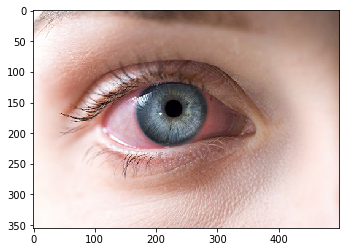

In [17]:
data = image.imread('./scraping/pink_eye/05ced86db0.jpg')
plt.imshow(data)
plt.show()

### Load images from local directory, resize, and store in list

In [6]:
def load_images_to_list(path, resize=True):
    loaded_images = list()
    for filename in listdir(path):
        # load image
        if filename != '.DS_Store' and filename != '.ipynb_checkpoints':
            img = Image.open(path + filename)
            # re-size
            if resize:
                img_resized = img.resize((200,200))
            img_data = np.asarray(img_resized)
            loaded_images.append(img_data)
    return loaded_images

In [7]:
pink_eye_images = load_images_to_list('./scraping/pink_eye/', True)

In [8]:
array = np.concatenate([img[np.newaxis] for img in pink_eye_images])

In [9]:
array.shape

(38, 200, 200, 3)